In [1]:
import pandas as pd
import yfinance as yf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# load validation data

# extract tickers
df = pd.read_csv('../../data/processed/quarterly/cluster_labels/2022_Q4_clusters.csv')
tickers = df['symbol'].unique().tolist()

start_date = '2021-04-01'
end_date = '2024-12-31'

prices = yf.download(tickers, start=start_date, end=end_date)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  496 of 496 completed


In [3]:
# corresponding date = 2 weeks after quarter end. quarter metrics will have become available 
quarters_dict = {
    "2021_Q1": "2021-04-21",
    "2021_Q2": "2021-07-21",
    "2021_Q3": "2021-10-21",
    "2021_Q4": "2022-01-21",
    "2022_Q1": "2022-04-21",
    "2022_Q2": "2022-07-21",
    "2022_Q3": "2022-10-21",
    "2022_Q4": "2023-01-21",
    "2023_Q1": "2023-04-21",
    "2023_Q2": "2023-07-21",
    "2023_Q3": "2023-10-21"
}

def returns(price_df):
    # 1day to 1day returns could be sensitive to market noise, calculate average instead

    start_period = prices.iloc[0:14]
    end_period = prices.iloc[-14:-1]

    start_period_avg = start_period.mean()
    end_period_avg = end_period.mean()
    
    returns_df = ((end_period_avg - start_period_avg) / start_period_avg).reset_index()
    returns_df.columns = ['symbol', 'returns']

    return returns_df


def get_validation(training_quarter):
    start_date = quarters_dict[training_quarter]
    end_date = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=365)
    filtered_prices = prices.loc[(prices.index > start_date) & (prices.index <= end_date)]

    returns_df = returns(filtered_prices)

    return returns_df

In [4]:
def get_eval(train_quarter):
    df_train = pd.read_csv(f'../../data/processed/quarterly/cluster_labels/{train_quarter}_clusters.csv')
    df_clustered = df_train[['symbol', 'cluster']].drop_duplicates()
    
    validation_df = get_validation(train_quarter)
    df_eval = df_clustered.merge(validation_df, on='symbol', how='inner')

    return df_eval

def performance(df_eval):
    performance_summary = df_eval.groupby('cluster')['returns'].agg(['mean', 'median', 'std', 'count'])
    performance_summary = performance_summary.sort_values(by='mean', ascending=False)

    return performance_summary

In [5]:
quarterly_performance = {}

for quarter in quarters_dict:
    eval_df = get_eval(quarter)
    performance_df = performance(eval_df)

    quarterly_performance[quarter] = performance_df

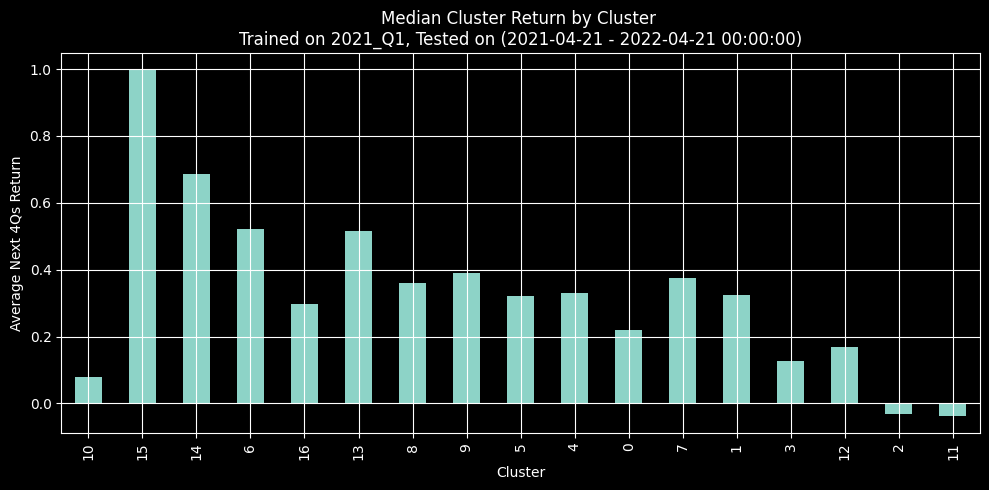

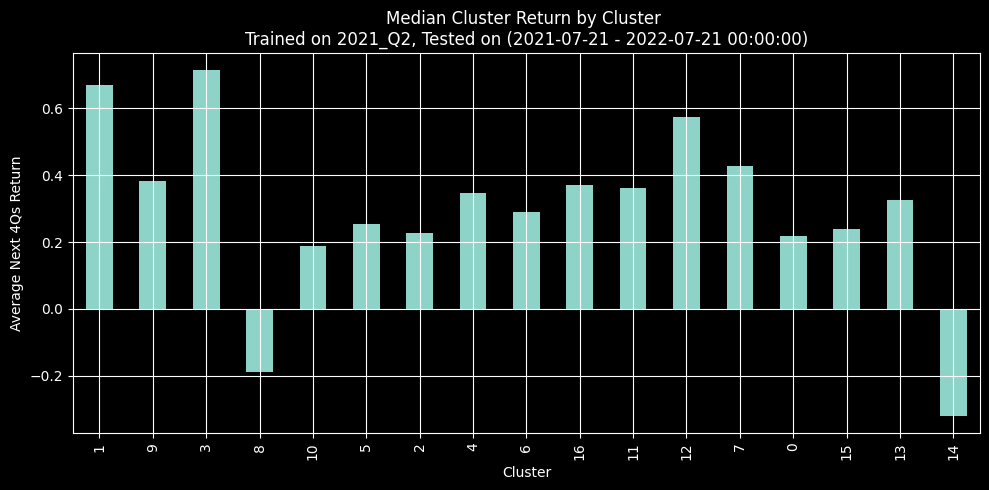

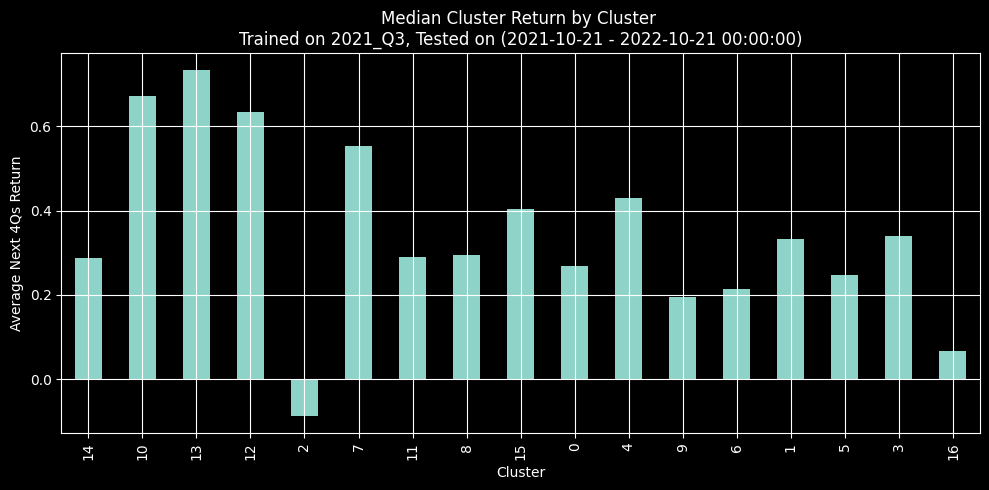

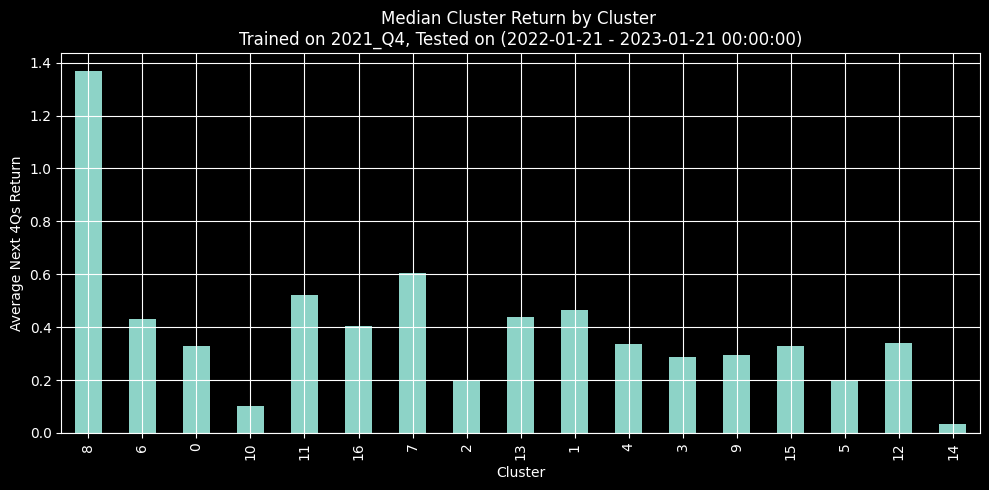

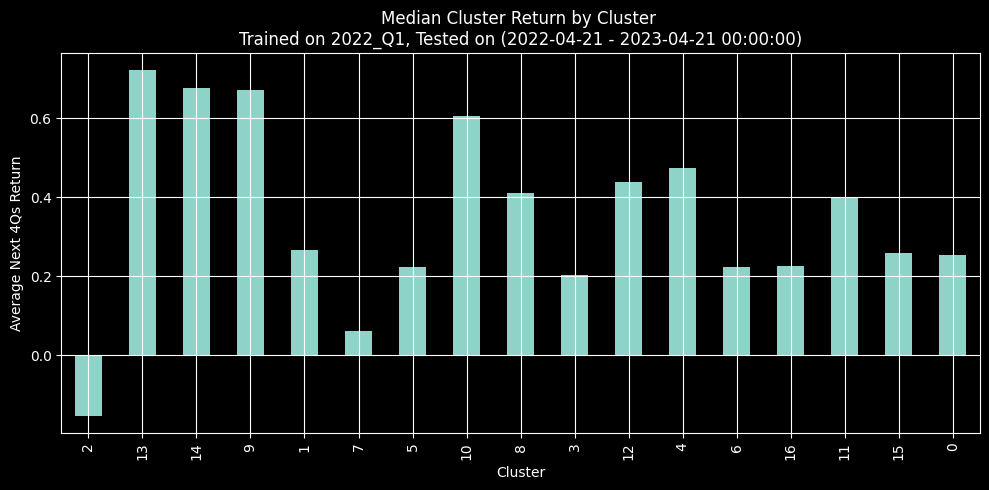

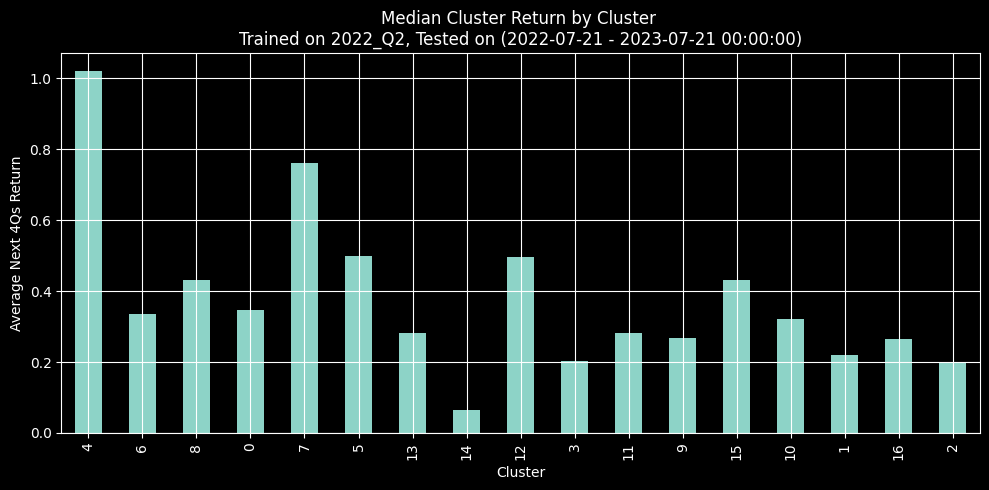

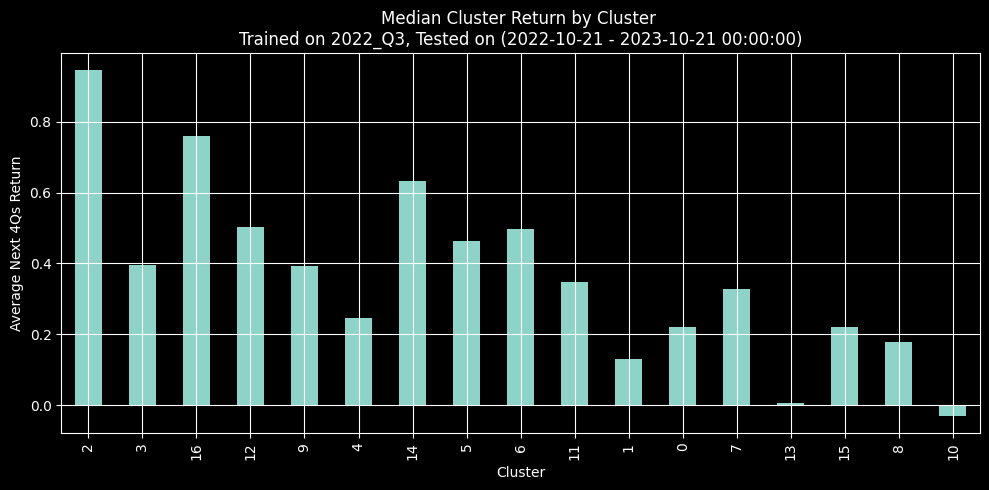

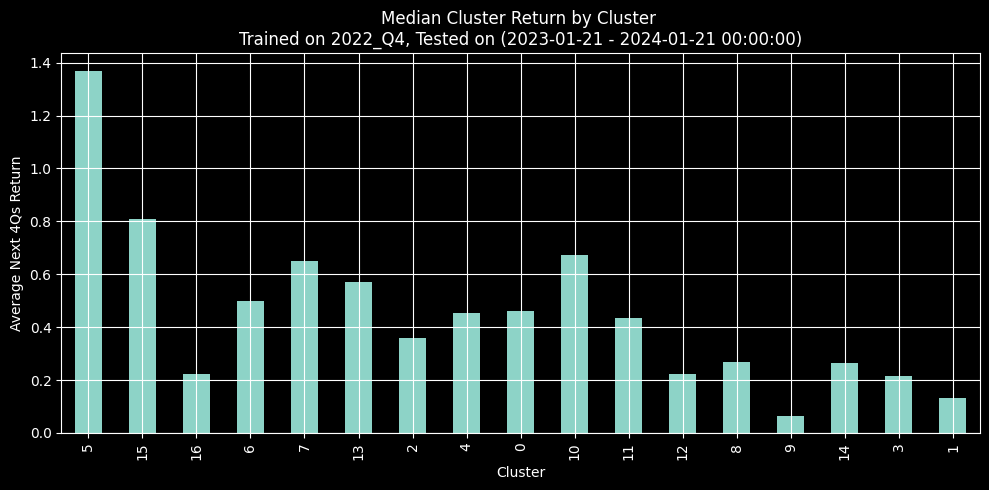

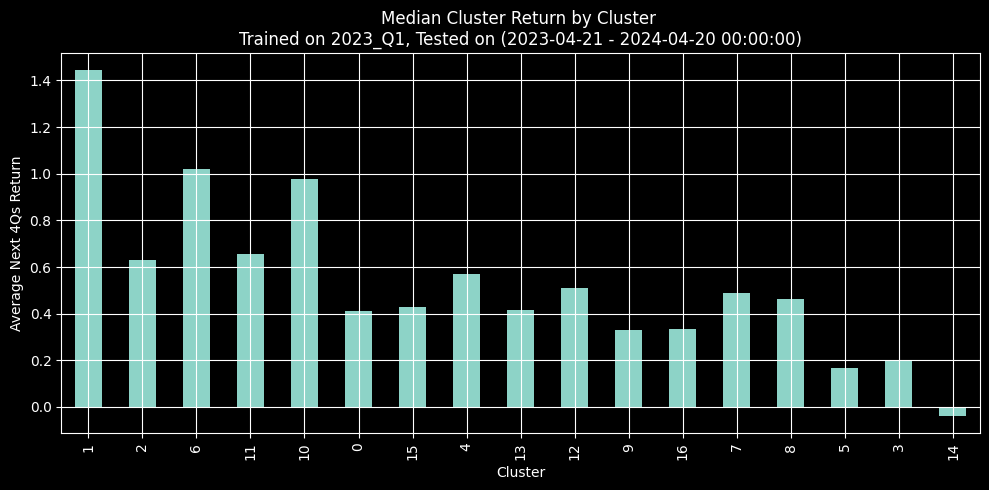

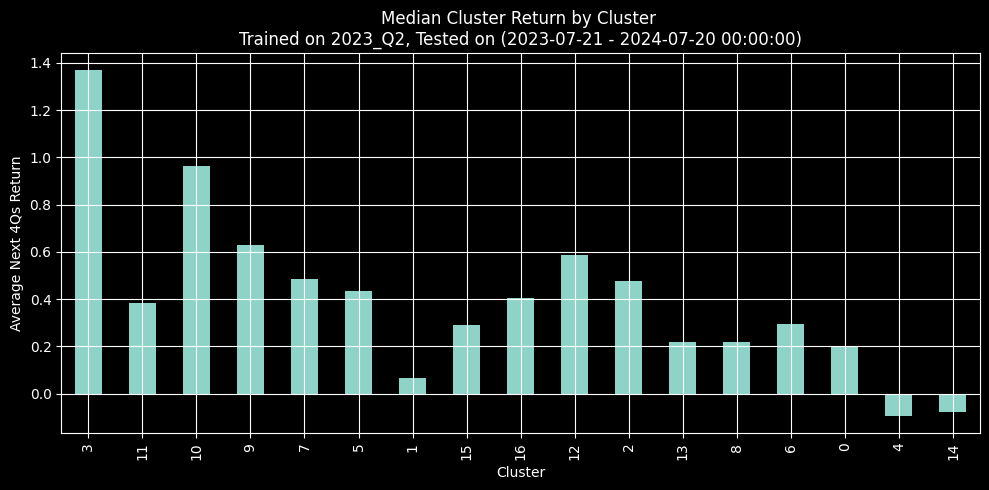

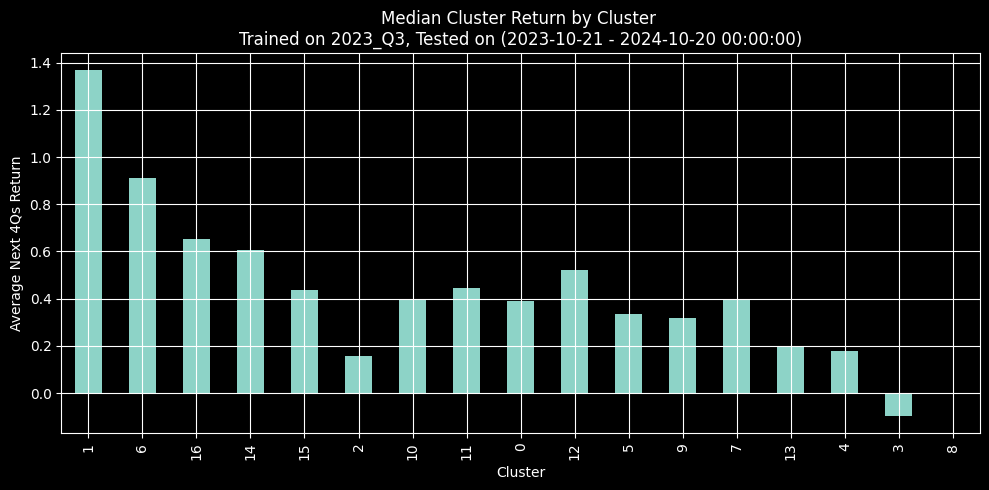

In [6]:
def plot(performance_df, quarter, by='median'):
    performance_df[by].plot(kind='bar', figsize=(10, 5))
    plt.title(f'Median Cluster Return by Cluster \nTrained on {quarter}, Tested on ({quarters_dict[quarter]} - {datetime.strptime(quarters_dict[quarter], "%Y-%m-%d") + timedelta(days=365)})')
    plt.ylabel('Average Next 4Qs Return')
    plt.xlabel('Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for quarter in quarterly_performance:
    performance_df = quarterly_performance[quarter]    
    plot(performance_df, quarter)